In [1]:
import sys
import os
import importlib
# Add the parent directory to the Python path
sys.path.append(os.path.abspath('..'))

import pybaseball


import IPython #type: ignore
import sqlite3
import pandas as pd # type: ignore
import numpy as np # type: ignore

import src
importlib.reload(src)
from src import *

In [7]:
print(type(get_roster("NYY", False)))

<class 'dict'>


In [3]:
hr = get_team_hits("NYY", False, 'home_run')
hits = get_team_hits("NYY", False, None)
store(hr, "2024_NYY", "home_runs")
store(hits, "2024_NYY", "hits")       

IPython.display.clear_output()

In [4]:
con = sqlite3.connect("2024_NYY")
cur = con.cursor()
cur.execute("SELECT DISTINCT player_name FROM home_runs").fetchall()

[('Narvaez, Carlos',),
 ('Trevino, Jose',),
 ('Wells, Austin',),
 ('Berti, Jon',),
 ('Cabrera, Oswaldo',),
 ('Chisholm Jr., Jazz',),
 ('LeMahieu, DJ',),
 ('Peraza, Oswald',),
 ('Rice, Ben',),
 ('Rizzo, Anthony',),
 ('Torres, Gleyber',),
 ('Vivas, Jorbit',),
 ('Volpe, Anthony',),
 ('Domínguez, Jasson',),
 ('Grisham, Trent',),
 ('Judge, Aaron',),
 ('Pereira, Everson',),
 ('Soto, Juan',),
 ('Verdugo, Alex',),
 ('Stanton, Giancarlo',)]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dimensionality Reduction and Clustering Libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

class BaseballClusterAnalysis:
    def __init__(self, data):
        """
        Initialize the baseball data clustering analysis
        
        Parameters:
        -----------
        data : pandas.DataFrame
            Input dataframe with baseball game data
        """
        self.original_data = data.copy()
        self.processed_data = None
        
    def preprocess_data(self, 
        numerical_features=[
            'release_speed', 'release_pos_x', 'release_pos_z', 
            'arm_angle', 'spray_angle', 'api_break_z_with_gravity', 
            'api_break_x_arm', 'api_break_x_batter_in'
        ],
        categorical_features=['pitch_type', 'batter', 'pitcher']
    ):
        """
        Preprocess data with advanced feature engineering
        
        Parameters:
        -----------
        numerical_features : list
            Numerical features to include in analysis
        categorical_features : list
            Categorical features to one-hot encode
        
        Returns:
        --------
        pandas.DataFrame
            Processed and transformed dataset
        """
        # Create a copy of the dataframe
        df = self.original_data.copy()
        
        # Handle missing values
        for feature in numerical_features:
            df[feature] = df[feature].fillna(df[feature].median())
        
        # Create preprocessing pipeline
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_features),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
            ])
        
        # Fit and transform data
        self.processed_data = preprocessor.fit_transform(df)
        
        # Get feature names after transformation
        onehot_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
        self.feature_names = np.concatenate([
            numerical_features, 
            onehot_columns
        ])
        
        return self.processed_data, self.feature_names
    
    def correlation_analysis(self, processed_data, feature_names):
        """
        Perform correlation analysis on processed data
        
        Parameters:
        -----------
        processed_data : numpy.ndarray
            Processed data array
        feature_names : list
            Names of features in processed data
        
        Returns:
        --------
        matplotlib.figure.Figure
            Correlation heatmap
        """
        # Convert to DataFrame for correlation
        df = pd.DataFrame(processed_data, columns=feature_names)
        
        plt.figure(figsize=(20, 16))
        correlation_matrix = df.corr()
        
        sns.heatmap(
            correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            linewidths=0.5, 
            fmt=".2f",
            square=True
        )
        plt.title('Feature Correlation Heatmap', fontsize=15)
        plt.tight_layout()
        return plt.gcf()
    
    def dimensionality_reduction(self, data, method='pca', n_components=2):
        """
        Reduce dimensionality of data
        
        Parameters:
        -----------
        data : numpy.ndarray
            Input data to reduce
        method : str, optional (default='pca')
            Dimensionality reduction method ('pca' or 'tsne')
        n_components : int, optional (default=2)
            Number of components to reduce to
        
        Returns:
        --------
        numpy.ndarray
            Reduced dimensionality data
        """
        if method == 'pca':
            reducer = PCA(n_components=n_components)
            reduced_data = reducer.fit_transform(data)
            
            # Explained variance plot
            plt.figure(figsize=(10, 6))
            plt.bar(
                range(1, len(reducer.explained_variance_ratio_) + 1), 
                reducer.explained_variance_ratio_
            )
            plt.xlabel('Principal Component')
            plt.ylabel('Explained Variance Ratio')
            plt.title('PCA Explained Variance')
            plt.show()
            
        elif method == 'tsne':
            reducer = TSNE(n_components=n_components)
            reduced_data = reducer.fit_transform(data)
        
        return reduced_data
    
    def kmeans_clustering(self, data, max_clusters=10):
        """
        Perform K-means clustering and determine optimal clusters
        
        Parameters:
        -----------
        data : numpy.ndarray
            Input data to cluster
        max_clusters : int, optional (default=10)
            Maximum number of clusters to test
        
        Returns:
        --------
        dict
            Clustering results and metrics
        """
        # Elbow method
        inertias = []
        silhouette_scores = []
        
        for k in range(2, max_clusters + 1):
            kmeans = KMeans(
                n_clusters=k, 
                random_state=42, 
                n_init=10
            )
            kmeans.fit(data)
            
            inertias.append(kmeans.inertia_)
            silhouette_scores.append(
                silhouette_score(data, kmeans.labels_)
            )
        
        # Plot Elbow Curve
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(range(2, max_clusters + 1), inertias, marker='o')
        plt.title('Elbow Curve')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Inertia')
        
        plt.subplot(1, 2, 2)
        plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
        plt.title('Silhouette Score')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Silhouette Score')
        plt.tight_layout()
        plt.show()
        
        # Optimal cluster selection (heuristic)
        optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
        
        # Perform clustering with optimal k
        kmeans = KMeans(
            n_clusters=optimal_k, 
            random_state=42, 
            n_init=10
        )
        labels = kmeans.fit_predict(data)
        
        return {
            'labels': labels,
            'centroids': kmeans.cluster_centers_,
            'optimal_clusters': optimal_k
        }
    
    def cluster_visualization(self, reduced_data, labels):
        """
        Visualize clusters in 2D space
        
        Parameters:
        -----------
        reduced_data : numpy.ndarray
            Dimensionality reduced data
        labels : numpy.ndarray
            Cluster labels
        """
        plt.figure(figsize=(12, 10))
        scatter = plt.scatter(
            reduced_data[:, 0], 
            reduced_data[:, 1], 
            c=labels, 
            cmap='viridis',
            alpha=0.7
        )
        plt.title('Baseball Player Clusters', fontsize=15)
        plt.xlabel('Dimension 1', fontsize=12)
        plt.ylabel('Dimension 2', fontsize=12)
        plt.colorbar(scatter, label='Cluster')
        plt.tight_layout()
        plt.show()
    
    def analyze_cluster_characteristics(self, data, labels, feature_names):
        """
        Analyze characteristics of each cluster
        
        Parameters:
        -----------
        data : numpy.ndarray
            Processed data
        labels : numpy.ndarray
            Cluster labels
        feature_names : list
            Names of features
        
        Returns:
        --------
        pandas.DataFrame
            Cluster characteristics
        """
        # Convert to DataFrame
        df = pd.DataFrame(data, columns=feature_names)
        df['Cluster'] = labels
        
        # Compute cluster centroids and characteristics
        cluster_summary = df.groupby('Cluster').agg(['mean', 'std'])
        
        return cluster_summary

def main(hr):
    # Initialize analysis
    analysis = BaseballClusterAnalysis(hr)
    
    # Preprocess data
    processed_data, feature_names = analysis.preprocess_data()
    
    # Correlation Analysis
    analysis.correlation_analysis(processed_data, feature_names)
    
    # Dimensionality Reduction
    reduced_data_pca = analysis.dimensionality_reduction(processed_data, method='pca')
    
    # K-means Clustering
    clustering_results = analysis.kmeans_clustering(processed_data)
    
    # Visualize Clusters
    analysis.cluster_visualization(reduced_data_pca, clustering_results['labels'])
    
    # Analyze Cluster Characteristics
    cluster_summary = analysis.analyze_cluster_characteristics(
        processed_data, 
        clustering_results['labels'], 
        feature_names
    )
    
    return {
        'processed_data': processed_data,
        'feature_names': feature_names,
        'clustering_results': clustering_results,
        'cluster_summary': cluster_summary
    }

results = main(hr)

ValueError: Shape of passed values is (299, 1), indices imply (299, 239)

In [68]:
# Inputs into our simulation
# omega_t = ['release_spin_rate'] # rpm
# v_t = ['launch_speed'] # mph
# theta = ['launch_angle'] # deg
# phi = ['spray_angle'] # deg
# phi_s = ['spin_axis'] # deg

variables = {
    'release_spin_rate': hr['release_spin_rate'].tolist(),
    'launch_speed': hr['launch_speed'].tolist(),
    'theta': hr['launch_angle'].tolist(),
    'phi': hr['spray_angle'].tolist(),
    'phi_s': hr['spin_axis'].tolist()
}

df = pd.DataFrame(variables, columns=[
    'release_spin_rate', 'launch_speed', 'theta', 'phi', 'phi_s'])

matrix = df.corr()

In [69]:
from statsmodels.stats.outliers_influence import variance_inflation_factor # type: ignore



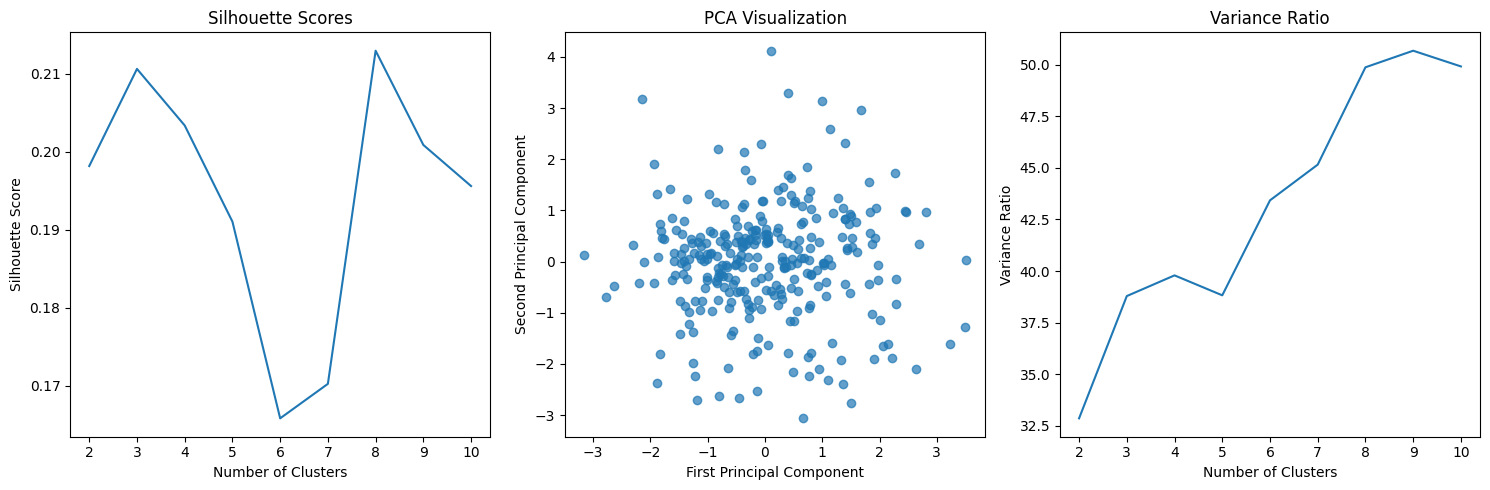

Feature Statistics:
       release_spin_rate  launch_speed  launch_angle  spray_angle   spin_axis
mean         2262.27551    105.756463     29.231293     4.281374  180.772109
std           322.56498      5.152885      5.509617    21.043045   67.712042
min           100.00000     90.300000     15.000000   -34.999667   13.000000
max          2981.00000    118.800000     45.000000    36.703696  342.000000

Silhouette Scores: [np.float64(0.1981810090473104), np.float64(0.21064589939278394), np.float64(0.20338910051439918), np.float64(0.19105000279431208), np.float64(0.16581421835834848), np.float64(0.17023974900536595), np.float64(0.21297895903081124), np.float64(0.20088811945637539), np.float64(0.19561544696238803)]

Variance Ratios: [np.float64(32.858028261673205), np.float64(38.78652358209785), np.float64(39.789755026663734), np.float64(38.82276233365582), np.float64(43.4272468151063), np.float64(45.1591364284808), np.float64(49.878099416459314), np.float64(50.68198599780189), np.float6

In [71]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_clustering_potential(df, features):
    """
    Analyze the potential for clustering in baseball hit data
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe with baseball hit data
    features : list
        List of features to use for clustering analysis
    
    Returns:
    --------
    dict : Comprehensive clustering analysis results
    """
    # Subset and clean data
    cluster_data = df[features].dropna()
    
    # Standardize features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(cluster_data)
    
    # Silhouette Analysis
    max_clusters = 10
    silhouette_scores = []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(scaled_data)
        score = silhouette_score(scaled_data, cluster_labels)
        silhouette_scores.append(score)
    
    # PCA for visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_data)
    
    # Feature variability
    feature_stats = cluster_data.agg(['mean', 'std', 'min', 'max'])
    
    # Variance Ratio (approximation)
    variance_ratios = []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(scaled_data)
        
        # Calculate between-cluster variance
        cluster_centers = kmeans.cluster_centers_
        total_center = np.mean(scaled_data, axis=0)
        between_cluster_variance = np.sum(
            [len(scaled_data[kmeans.labels_ == i]) * 
             np.sum((cluster_centers[i] - total_center)**2) 
             for i in range(n_clusters)]
        )
        
        # Calculate within-cluster variance
        within_cluster_variance = np.sum(
            [np.sum(np.var(scaled_data[kmeans.labels_ == i], axis=0)) 
             for i in range(n_clusters)]
        )
        
        variance_ratio = between_cluster_variance / within_cluster_variance
        variance_ratios.append(variance_ratio)
    
    # Plotting
    plt.figure(figsize=(15, 5))
    
    # Silhouette Scores
    plt.subplot(131)
    plt.plot(range(2, max_clusters + 1), silhouette_scores)
    plt.title('Silhouette Scores')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    
    # PCA Visualization
    plt.subplot(132)
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
    plt.title('PCA Visualization')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    
    # Variance Ratios
    plt.subplot(133)
    plt.plot(range(2, max_clusters + 1), variance_ratios)
    plt.title('Variance Ratio')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Variance Ratio')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'silhouette_scores': silhouette_scores,
        'feature_stats': feature_stats,
        'variance_ratios': variance_ratios,
        'explained_variance_ratio': pca.explained_variance_ratio_
    }

# Example usage
# Assuming 'df' is your DataFrame
features_to_analyze = [
    'release_spin_rate', 
    'launch_speed', 
    'launch_angle', 
    'spray_angle', 
    'spin_axis'
]

results = analyze_clustering_potential(hr, features_to_analyze)
print("Feature Statistics:\n", results['feature_stats'])
print("\nSilhouette Scores:", results['silhouette_scores'])
print("\nVariance Ratios:", results['variance_ratios'])
print("\nPCA Explained Variance Ratio:", results['explained_variance_ratio'])

In [79]:
def analyze_hit_differences(df):
    # Group-level analysis
    grouped_stats = df.groupby('player_name').agg({
        'launch_speed': ['mean', 'std'],
        'launch_angle': ['mean', 'std'],
        'spray_angle': ['mean', 'std'],
        'hit_distance_sc': ['mean', 'std']
    })
    
    # ANOVA or Kruskal-Wallis test to check if differences are statistically significant
    from scipy import stats
    
    # Test if hit characteristics differ significantly between players
    launch_speed_f_stat, launch_speed_p_val = stats.f_oneway(
        *[group['launch_speed'].values for name, group in df.groupby('player_name')]
    )
    
    launch_angle_f_stat, launch_angle_p_val = stats.f_oneway(
        *[group['launch_angle'].values for name, group in df.groupby('player_name')]
    )

    spray_angle_f_stat, spray_angle_p_val = stats.f_oneway(
        *[group['spray_angle'].values for name, group in df.groupby('player_name')]
    )

    release_spin_rate_f_stat, release_spin_rate_p_val = stats.f_oneway(
        *[group['release_spin_rate'].values for name, group in df.groupby('player_name')]
    )

    spin_axis_f_stat, spin_axis_p_val = stats.f_oneway(
        *[group['spin_axis'].values for name, group in df.groupby('player_name')]
    )


    
    return {
        'launch_speed_significance': launch_speed_p_val,
        'launch_angle_significance': launch_angle_p_val,
        'spray_angle_significance': spray_angle_p_val,
        'release_spin_rate_significance': release_spin_rate_p_val,
        'spin_axis_significce': spin_axis_p_val,
        
    }

In [44]:
def create_hit_probability_map(df):
    # Create a 2D grid representing stadium sections
    
    # Define stadium grid (adjust based on Yankee Stadium dimensions)
    x_bins = np.linspace(df['hc_x'].min(), df['hc_x'].max(), 20)
    y_bins = np.linspace(df['hc_y'].min(), df['hc_y'].max(), 20)
    
    # Calculate hit probability for each grid section
    hit_probabilities, _, _ = np.histogram2d(
        df['hc_x'], 
        df['hc_y'], 
        bins=[x_bins, y_bins]
    )
    
    # Normalize to get probability distribution
    hit_probabilities = hit_probabilities / hit_probabilities.sum()
    
    return {
        'probability_map': hit_probabilities,
        'x_edges': x_bins,
        'y_edges': y_bins
    }

# Visualization
def plot_hit_probability_map(probability_map):
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        probability_map['probability_map'], 
        cmap='YlOrRd', 
        annot=True, 
        fmt='.4f'
    )
    plt.title('Hit Probability Map')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()

In [45]:
def extract_advanced_features(df):
    # Combine multiple features to create more distinctive signatures
    df['hit_efficiency'] = df['launch_speed'] * np.cos(np.radians(df['launch_angle']))
    df['spin_impact'] = df['release_spin_rate'] * df['launch_speed']
    
    # Create categorical features
    df['launch_category'] = pd.cut(
        df['launch_angle'], 
        bins=[-90, 0, 30, 90], 
        labels=['ground_ball', 'line_drive', 'fly_ball']
    )
    
    return df

In [80]:
#print(analyze_hit_differences(hr))
print(analyze_hit_differences(hr))

{'launch_speed_significance': np.float64(8.871124608841957e-27), 'launch_angle_significance': np.float64(0.00024019090876652797), 'spray_angle_significance': np.float64(nan), 'release_spin_rate_significance': np.float64(nan), 'spin_axis_significce': np.float64(nan)}


In [84]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy import stats

def analyze_player_modeling_strategy(df, target_variables):
    """
    Comprehensive analysis to determine best modeling approach for players
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe with baseball hit data
    target_variables : list
        List of variables to analyze
    
    Returns:
    --------
    dict : Analysis results for player modeling strategy
    """
    # Group data by player
    def aggregate_player_stats(group):
        return {
            var: {
                'mean': group[var].mean(),
                'std': group[var].std(),
                'median': group[var].median(),
                'variance': group[var].var()
            } for var in target_variables
        }
    
    # Aggregate player-level statistics
    player_stats = df.groupby('player_name').apply(aggregate_player_stats).to_dict()
    
    # Prepare data for clustering analysis
    player_features = []
    player_names = []
    for player, stats_dict in player_stats.items():
        player_features.append([
            stats_dict[var]['mean'] for var in target_variables
        ])
        player_names.append(player)
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(player_features)
    
    # Clustering Analysis
    max_clusters = min(10, len(player_features) - 1)
    clustering_results = {
        'silhouette_scores': [],
        'within_cluster_variance': [],
        'between_cluster_variance': []
    }
    
    for n_clusters in range(2, max_clusters + 1):
        # Perform K-means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(scaled_features)
        
        # Silhouette Score
        try:
            silhouette_avg = silhouette_score(scaled_features, cluster_labels)
            clustering_results['silhouette_scores'].append(silhouette_avg)
        except Exception:
            clustering_results['silhouette_scores'].append(np.nan)
        
        # Variance Analysis
        cluster_centers = kmeans.cluster_centers_
        overall_mean = np.mean(scaled_features, axis=0)
        
        # Between-cluster variance
        between_var = np.sum([
            len(scaled_features[cluster_labels == i]) * 
            np.sum((cluster_centers[i] - overall_mean)**2)
            for i in range(n_clusters)
        ])
        clustering_results['between_cluster_variance'].append(between_var)
        
        # Within-cluster variance
        within_var = np.sum([
            np.sum(np.var(scaled_features[cluster_labels == i], axis=0))
            for i in range(n_clusters)
        ])
        clustering_results['within_cluster_variance'].append(within_var)
    
    # Individual vs. Clustered Performance Estimation
    individual_vs_cluster_performance = {}
    for var in target_variables:
        # Collect individual player variances
        individual_variances = [
            player_stats[player][var]['variance'] for player in player_stats
        ]
        
        # Compare to clustered variance
        cluster_variance_estimate = np.mean(individual_variances)
        
        # Perform statistical test
        individual_vs_cluster_performance[var] = {
            'mean_individual_variance': np.mean(individual_variances),
            'median_individual_variance': np.median(individual_variances),
            'total_dataset_variance': df[var].var(),
        }
    
    # Detailed Printing
    print("Clustering Analysis Results:")
    print("\nSilhouette Scores:")
    for i, score in enumerate(clustering_results['silhouette_scores'], start=2):
        print(f"{i} clusters: {score}")
    
    print("\nBetween-Cluster Variance:")
    for i, variance in enumerate(clustering_results['between_cluster_variance'], start=2):
        print(f"{i} clusters: {variance}")
    
    print("\nWithin-Cluster Variance:")
    for i, variance in enumerate(clustering_results['within_cluster_variance'], start=2):
        print(f"{i} clusters: {variance}")
    
    print("\nIndividual vs. Cluster Performance:")
    for var, performance in individual_vs_cluster_performance.items():
        print(f"\n{var} Analysis:")
        for key, value in performance.items():
            print(f"  {key}: {value}")
    
    # Print additional player-level insights
    print("\nPlayer-Level Variance Summary:")
    for var in target_variables:
        print(f"\n{var} Variance Summary:")
        variances = [player_stats[player][var]['variance'] for player in player_stats]
        print(f"  Min Variance: {np.min(variances)}")
        print(f"  Max Variance: {np.max(variances)}")
        print(f"  Mean Variance: {np.mean(variances)}")
        print(f"  Median Variance: {np.median(variances)}")
    
    return {
        'player_level_stats': player_stats,
        'clustering_analysis': clustering_results,
        'individual_vs_cluster_performance': individual_vs_cluster_performance,
        'player_names': player_names
    }

# Example usage
target_variables = [
    'release_spin_rate',  # omega_t
    'launch_speed',       # v_t
    'launch_angle',       # theta
    'spray_angle',        # phi
    'spin_axis'           # phi_s
]

results = analyze_player_modeling_strategy(hr, target_variables)

Clustering Analysis Results:

Silhouette Scores:
2 clusters: 0.13392106374297538
3 clusters: 0.11086979318082987
4 clusters: 0.15569685532465086
5 clusters: 0.1687518700849588
6 clusters: 0.10955528031580639
7 clusters: 0.15879165108812132
8 clusters: 0.20250251228599545
9 clusters: 0.23601777513868671
10 clusters: 0.14511699759330277

Between-Cluster Variance:
2 clusters: 7.2788628395618336
3 clusters: 17.953425605015692
4 clusters: 37.48498236974439
5 clusters: 52.1616625134482
6 clusters: 58.69177184750902
7 clusters: 74.34845729776578
8 clusters: 82.22690296439083
9 clusters: 88.06176414576045
10 clusters: 89.45008215949102

Within-Cluster Variance:
2 clusters: 4.880059850549377
3 clusters: 6.4482040069590525
4 clusters: 5.515607402417951
5 clusters: 7.63635629448426
6 clusters: 8.189709712175747
7 clusters: 4.588413021833857
8 clusters: 3.687354663787519
9 clusters: 3.3240706143799503
10 clusters: 3.4989627268718957

Individual vs. Cluster Performance:

release_spin_rate Analysis:

C:\Users\lukat\AppData\Local\Temp\ipykernel_34748\1768280457.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  player_stats = df.groupby('player_name').apply(aggregate_player_stats).to_dict()


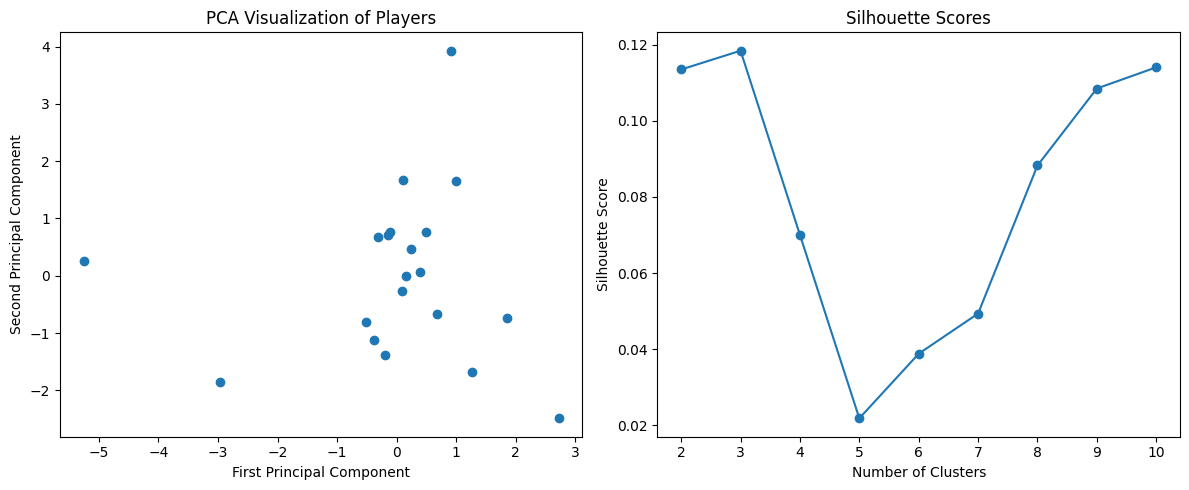

In [90]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import numpy as np

def identify_player_types(df, features):
    # Prepare data
    player_aggregates = df.groupby('player_name')[features].agg(['mean', 'std'])

    # Flatten multi-level columns
    player_aggregates.columns = ['_'.join(col).strip() for col in player_aggregates.columns.values]

    # Handle missing values
    player_aggregates.fillna(player_aggregates.mean(), inplace=True)

    # Standardize features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(player_aggregates)

    # Ensure no infinite values
    scaled_data[np.isinf(scaled_data)] = np.nan
    scaled_data = np.nan_to_num(scaled_data)

    # Dimensionality Reduction
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_data)

    # Multiple Clustering Approaches
    kmeans_results = []
    for n_clusters in range(2, 11):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(scaled_data)

        kmeans_results.append({
            'n_clusters': n_clusters,
            'silhouette_score': silhouette_score(scaled_data, cluster_labels),
            'cluster_centers': kmeans.cluster_centers_
        })

    return {
        'player_aggregates': player_aggregates,
        'kmeans_results': kmeans_results,
        'pca_result': pca_result
    }

# Visualization
def visualize_player_types(results):
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # PCA Scatter Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.scatter(results['pca_result'][:, 0], results['pca_result'][:, 1])
    plt.title('PCA Visualization of Players')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    
    # Silhouette Scores
    plt.subplot(122)
    silhouette_scores = [r['silhouette_score'] for r in results['kmeans_results']]
    plt.plot(range(2, 11), silhouette_scores, marker='o')
    plt.title('Silhouette Scores')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    
    plt.tight_layout()
    plt.show()

# Features to use for clustering
features_for_clustering = [
    'release_spin_rate',
    'launch_speed',
    'launch_angle',
    'spray_angle',
    'spin_axis'
]

results = identify_player_types(hr, features_for_clustering)
visualize_player_types(results)